<a href="https://colab.research.google.com/github/Zarar-Azwar/OCR-Florence2-Toolkit/blob/main/OCR_Florence2_Toolkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import random
import requests
import copy
import torch
import json
import os
import numpy as np
from pathlib import Path
import cv2
import re
from google.colab import files
%matplotlib inline


In [24]:
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']

#### Microsoft Florence

In [2]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

#### Florence 2 Inference

In [3]:
def run_example(task_prompt,image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    print("Prompt: ",prompt)
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

#### Save Annotations

In [4]:
def save_ocr_regions(data, output_dir="ocr_output"):
    """
    Save OCR regions and annotations in multiple formats for different use cases.

    Args:
        data (dict): Dictionary containing OCR results with regions and labels
        output_dir (str): Directory to save the output files
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Extract regions and labels
    regions = data['<OCR_WITH_REGION>']
    quad_boxes = regions['quad_boxes']
    labels = regions['labels']

    # 1. Save as JSON for easy programmatic access
    json_output = {
        'regions': [
            {
                'coordinates': box,
                'text': label,
                'bbox': {
                    'x1': min(box[0::2]),
                    'y1': min(box[1::2]),
                    'x2': max(box[0::2]),
                    'y2': max(box[1::2])
                }
            }
            for box, label in zip(quad_boxes, labels)
        ]
    }

    with open(os.path.join(output_dir, 'ocr_regions.json'), 'w', encoding='utf-8') as f:
        json.dump(json_output, f, indent=2)

    # 2. Save as YOLO format (normalized coordinates)
    def convert_to_yolo(box, img_width=700, img_height=800):
        x1, y1 = min(box[0::2]), min(box[1::2])
        x2, y2 = max(box[0::2]), max(box[1::2])

        # Calculate center x, center y, width, height
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        width = x2 - x1
        height = y2 - y1

        # Normalize
        center_x /= img_width
        center_y /= img_height
        width /= img_width
        height /= img_height

        return [center_x, center_y, width, height]

    with open(os.path.join(output_dir, 'ocr_regions.txt'), 'w', encoding='utf-8') as f:
        for box, label in zip(quad_boxes, labels):
            yolo_coords = convert_to_yolo(box)
            f.write(f"0 {' '.join(map(str, yolo_coords))} # {label}\n")

    # 3. Save human-readable format
    with open(os.path.join(output_dir, 'ocr_regions_readable.txt'), 'w', encoding='utf-8') as f:
        for i, (box, label) in enumerate(zip(quad_boxes, labels), 1):
            f.write(f"Region {i}:\n")
            f.write(f"Text: {label}\n")
            f.write("Coordinates (x1,y1,x2,y2,x3,y3,x4,y4):\n")
            coords_str = ", ".join(f"({box[i]:.2f}, {box[i+1]:.2f})"
                                 for i in range(0, len(box), 2))
            f.write(f"{coords_str}\n")
            f.write("Bounding Box:\n")
            f.write(f"Top-left: ({min(box[0::2]):.2f}, {min(box[1::2]):.2f})\n")
            f.write(f"Bottom-right: ({max(box[0::2]):.2f}, {max(box[1::2]):.2f})\n")
            f.write("-" * 50 + "\n")

    # 4. Save as CSV for spreadsheet compatibility
    import csv
    with open(os.path.join(output_dir, 'ocr_regions.csv'), 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Region', 'Text', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])
        for i, (box, label) in enumerate(zip(quad_boxes, labels), 1):
            writer.writerow([i, label] + box)

    return {
        'message': f'OCR regions saved in {output_dir}',
        'files_created': [
            'ocr_regions.json',
            'ocr_regions.txt',
            'ocr_regions_readable.txt',
            'ocr_regions.csv'
        ]
    }

#### Draw Bounding Box

In [27]:
def draw_ocr_bboxes(image, prediction, scale=1,output_path="annotated_image.jpg"):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    image.save(output_path)
    return image,output_path

    # display(image)

#### Display Tree

In [38]:
def generate_tree(path, prefix="", ignore_patterns=None):
    if ignore_patterns is None:
        ignore_patterns = ['.git', '__pycache__', '.pytest_cache', '.venv', 'venv']

    # Convert path to Path object
    path = Path(path)

    # Initialize tree string
    tree = []

    # Get directory contents
    try:
        contents = list(path.iterdir())
    except PermissionError:
        return f"{prefix}├── {path.name} [Permission Denied]\n"

    # Sort contents (directories first, then files)
    contents.sort(key=lambda x: (not x.is_dir(), x.name.lower()))

    # Process each item
    for i, item in enumerate(contents):
        # Skip ignored patterns
        if any(pattern in str(item) for pattern in ignore_patterns):
            continue

        # Check if this is the last item
        is_last = i == len(contents) - 1

        # Choose connector based on whether this is the last item
        connector = "└── " if is_last else "├── "

        # Add item to tree
        tree.append(f"{prefix}{connector}{item.name}")

        # If item is directory, recursively process its contents
        if item.is_dir():
            # Choose new prefix based on whether this is the last item
            new_prefix = prefix + ("    " if is_last else "│   ")
            subtree = generate_tree(item, new_prefix, ignore_patterns)
            tree.append(subtree)

    return "\n".join(tree)

def print_directory_tree(path, output_file=None, ignore_patterns=None):
    """
    Print and optionally save the directory tree structure.

    Args:
        path (str): Directory path to generate tree for
        output_file (str, optional): File to save the tree structure
        ignore_patterns (list, optional): List of patterns to ignore
    """
    # Get absolute path
    abs_path = os.path.abspath(path)

    # Generate header
    header = f"Directory Tree for: {abs_path}\n"
    separator = "=" * len(header) + "\n"

    # Generate tree
    tree = generate_tree(path, ignore_patterns=ignore_patterns)

    # Combine all parts
    output = f"{header}{separator}{tree}"

    # Print to console
    print(output)

    # Save to file if requested
    if output_file:
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(output)
        print(f"\nTree structure saved to: {output_file}")

#### Driver Function

In [45]:
def run_ocr():
    uploaded = files.upload()
    filename = next(iter(uploaded))
    image = Image.open(filename).convert('RGB')

    # Get user input for OCR type
    ocr_type = input("Enter OCR type (ocr/ocr_with_regions): ").lower().strip()

    if ocr_type == "ocr":
        # Perform basic OCR
        task_prompt = '<OCR>'
        text=run_example(task_prompt,image=image)

        # Clean the text
        cleaned_text = clean_text(text['<OCR>'])

        return cleaned_text

    elif ocr_type == "ocr_with_regions":
        # Get regions and coordinates
        task_prompt = '<OCR_WITH_REGION>'
        results = run_example(task_prompt,image=image)
        output_dir="ocr_output"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # Save OCR regions
        save_ocr_regions(data=results,output_dir=output_dir)
        output_image = copy.deepcopy(image)
        w, h = output_image.size
        scale = 800 / max(w, h)
        new_output_image = output_image.resize((int(w * scale), int(h * scale)))
        image,output_path=draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)
        display(image)

        print(f"Annotation is written in {output_path}")
        print_directory_tree(output_dir)
        return output_path

    else:
        return {"error": "Invalid OCR type. Please choose 'ocr' or 'ocr_with_regions'"}

def clean_text(text):
    """Clean and format the OCR text."""
    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters except basic punctuation
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    # Fix common OCR errors
    text = text.replace('|', 'I')
    text = text.replace('0', 'O')
    # Normalize spacing around punctuation
    text = re.sub(r'\s*([.,!?])\s*', r'\1 ', text)
    return text.strip()



## Example Running

###### Example Running with OCR
1. Upload Image
2. Enter OCR

###### Example Running OCR with Region
1. Upload Image
2. Enter ocr_with_regions

In [31]:
run_ocr()

Saving 12.jpg to 12 (1).jpg
Enter OCR type (ocr/ocr_with_regions): ocr
Prompt:  <OCR>


'Flowers are a true gift from God. They are beautiful. All of them. One of lifes pleasures is looking at flowers. If you look at them really closely, its amazing just how beautiful they are. There colours are so rich and deep. I dont know of everything in the world most set than a rose or more yellow than a tulip. Flowers seem to be a big big of every culture. People give flowers a gifts, change them in their houses, grow them in thar gardens. Some people can come home their daughters flowers, every time I cant imagine their being the world would be without flowers, Im always coming across new flowers, Every time I treat all of another country. I find lots of flowers I see never see before. It must be to be a be and yand all day flying from flowers to flower. Roses are my favorite flowers, They are the perfect flowers - beautiful in every way. I love the shape of roses and their beautiful colours. Looking at them is like looking at a world of nature. The colours are oo deep and pure, a

Saving medical.jpg to medical (6).jpg
Enter OCR type (ocr/ocr_with_regions): ocr_with_regions
Prompt:  <OCR_WITH_REGION>


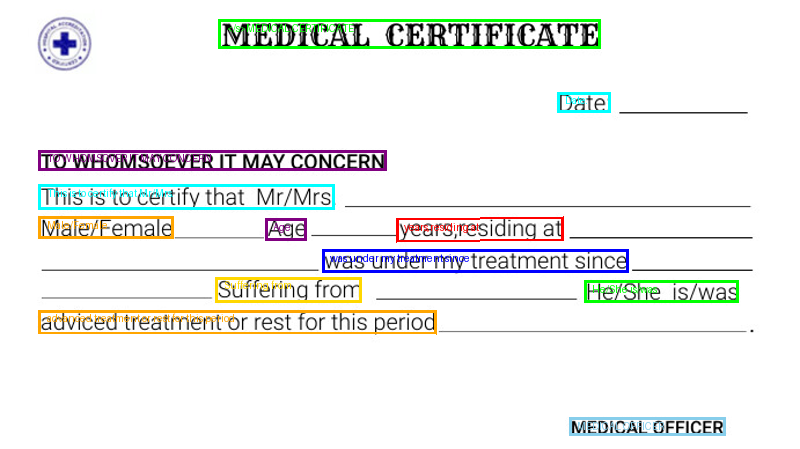

Annotation is written in annotated_image.jpg
Directory Tree for: /content/ocr_output
├── ocr_regions.csv
├── ocr_regions.json
├── ocr_regions.txt
└── ocr_regions_readable.txt


'annotated_image.jpg'

In [46]:
run_ocr()

#### Delete Output folder (if required)

In [18]:
rm -rf /content/ocr_output